In [148]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [149]:
pp = Preprocess(df_transaction, df_property)

In [35]:
use_features = pp.get_feature_list()

In [36]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(68908, 15)


,zip,pool,sold_price,impr_over_land,sqft,lat,num_bath,view,num_bed,sqft_zip_avg,sold_price_zip_avg,id,lon,sqft_price_zip_avg,date
0,92131,0,346500,1.015708,1064,32.93745,2.0,0,2.0,2162.542982,698046.052632,1428580,-117.10164,334.725439,2015-10-01
18277,92069,1,768000,2.009366,3172,33.16329,3.0,1,5.0,1851.554437,460152.790485,1428680,-117.15680,259.656908,2015-10-01
19369,92101,0,603000,1.680000,1108,32.72103,2.0,1,2.0,1069.848516,576143.807574,1428594,-117.15701,524.557318,2015-10-01
21323,91978,0,420000,1.791746,1991,32.73226,3.0,0,3.0,1698.890244,379536.585366,1428595,-116.96510,235.934959,2015-10-01
21324,91978,0,2000,2.501813,1530,32.72749,2.0,0,4.0,1698.890244,379536.585366,1428640,-116.95756,235.934959,2015-10-01


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [70]:
monthly_volume

2801

In [37]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57424, 34452, 11484
[dp] train/valid/test size: 45939, 11485, 11484
[dp] validation step is skipped


127622.54965104254

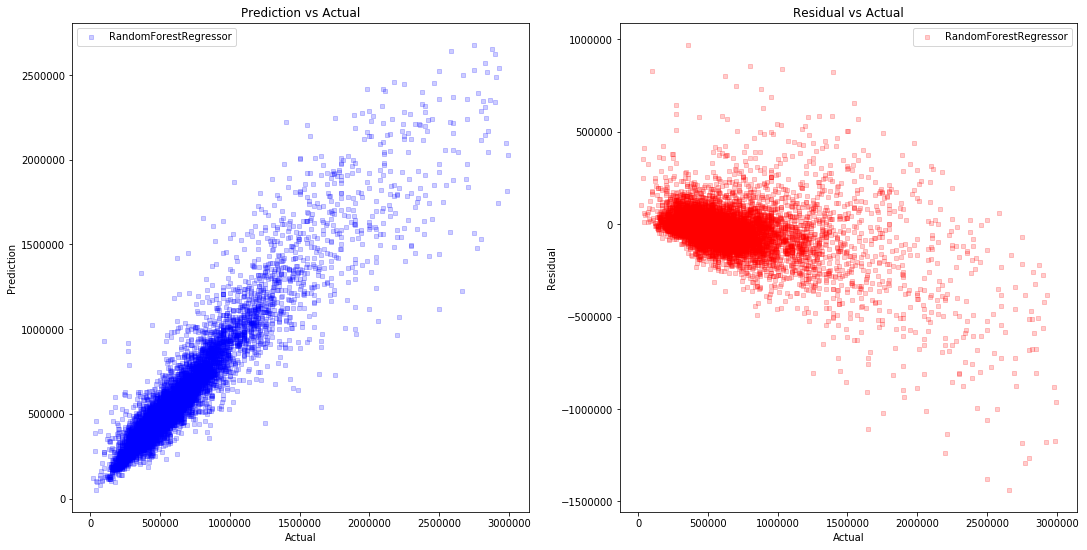

In [38]:
mm.plot_residual()

In [39]:
#df_check = mm.get_result_df(pp)
df_check = pp.debug(mm.get_result_df())

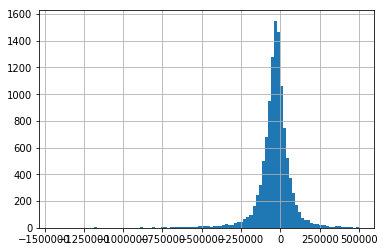

In [40]:
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

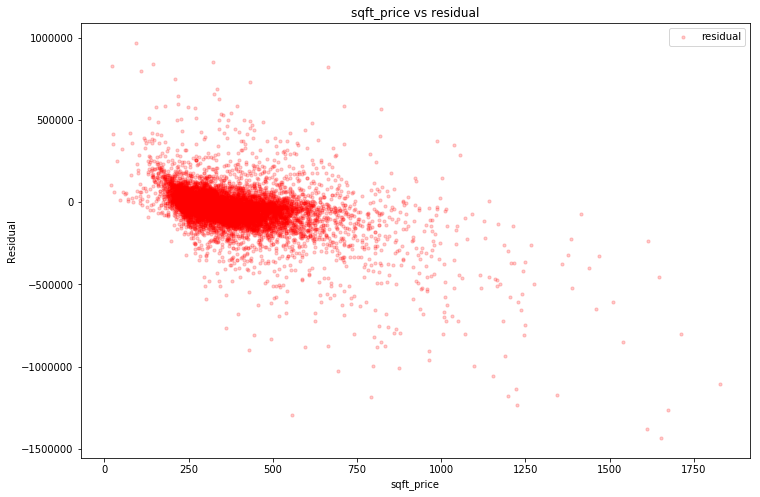

In [41]:
df_check['sqft_price'] = df_check['sold_price'] / df_check['sqft']
plt.figure(figsize=(12,8))
plt.scatter(df_check['sqft_price'], df_check['residual'], s=10, c='r', alpha=0.2)
plt.xlabel('sqft_price')
plt.ylabel('Residual')
plt.legend(loc='best');
plt.title('sqft_price vs residual')

plt.show()

In [42]:
def remeasure(df_check, threshold=200000):
    removed = df_check[df_check['residual']>=threshold]
    print("removed records:", removed.shape[0])
    df_left = df_check[df_check['residual']<threshold]
    return sqrt(mean_squared_error(df_left['predict'], df_left['sold_price']))

In [43]:
remeasure(df_check)

removed records: 230


117832.90645135197

In [44]:
df_check[df_check['sqft_price']>1000][:3]

,pin,str_no,street,st_type,city,zip,land_use_subcode,date,sqft,num_bed,...,sold_price_zip_avg,impr_over_land,lon,lat,zip,id,sold_price,predict,residual,sqft_price
41,3004101700,410,10TH,ST,DEL MAR,92014,11,2017-06-09,1517,4.0,...,1.522431e+06,0.048667,-117.26197,32.95486,92014,1499399,1573000,1.919233e+06,346232.617549,1036.914964
59,5362522200,364,GLORIETTA,BLVD,CORONADO,92118,11,2017-06-09,1487,3.0,...,1.491386e+06,0.103448,-117.16830,32.69297,92118,1499486,1600000,1.375599e+06,-224400.579208,1075.991930
247,2980532044,441,SIERRA,AVE,SOLANA BEACH,92075,17,2017-06-12,1134,2.0,...,1.139647e+06,0.257282,-117.27184,32.98626,92075,1499763,1295000,1.301794e+06,6793.562305,1141.975309


### removing outliers
* by option clean=True which remove outliers that are 1.5 IQR outside of Hinge-spread

In [63]:
df_track_clean = pp.dataset(feature='delivered', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track_clean.shape[0] / 24)
print(df_track_clean.shape)
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(67231, 15)


(68908, 15)

In [52]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track_clean, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 56027, 33612, 11204
[dp] train/valid/test size: 44821, 11206, 11204
[dp] validation step is skipped


112053.4225615402

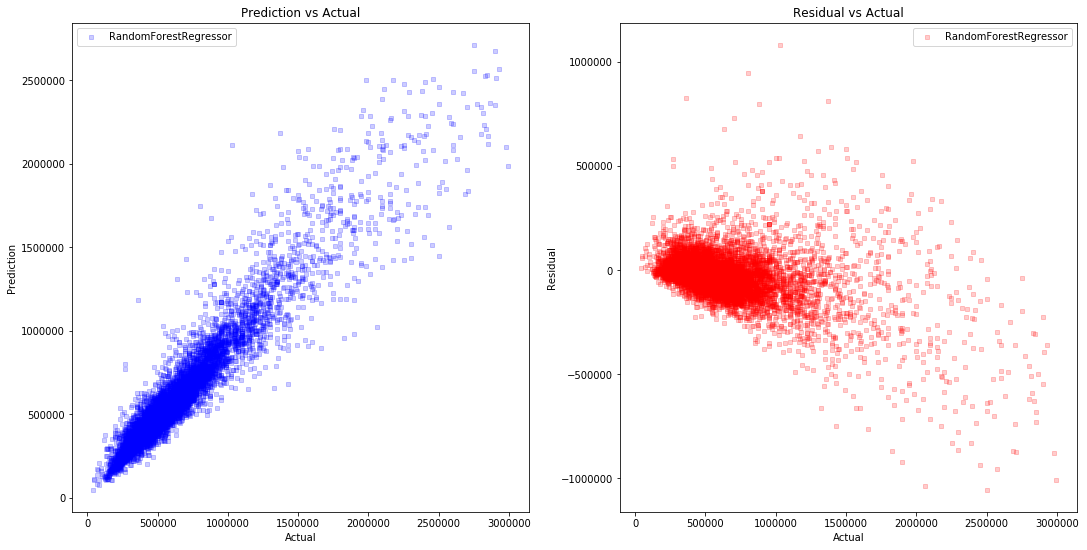

In [53]:
mm.plot_residual()

In [54]:
df_check_clean = pp.debug(mm.get_result_df())
remeasure(df_check_clean)

removed records: 188


102841.67641243408

In [55]:
df_check_clean[df_check_clean['residual']>600000][:3]

,pin,str_no,street,st_type,city,zip,land_use_subcode,date,sqft,num_bed,...,sqft_price_zip_avg,sold_price_zip_avg,impr_over_land,lon,lat,zip,id,sold_price,predict,residual
3565,4496701800,3636,CURTIS,ST,SAN DIEGO,92106,11,2017-07-11,3318,4.0,...,502.090468,9.634782e+05,0.958866,-117.22378,32.74331,92106,1503442,700000,1.427594e+06,727593.745835
4516,2982832600,839,IDA,AVE,SOLANA BEACH,92075,11,2017-07-20,2487,3.0,...,632.922607,1.139647e+06,0.183824,-117.25607,32.98449,92075,1504637,805000,1.750075e+06,945074.541855
7426,1292922400,1919,GRAND,AVE,SAN DIEGO,92109,11,2017-08-17,2368,3.0,...,539.114574,7.214368e+05,1.986509,-117.23439,32.79908,92109,1508101,635000,1.312043e+06,677042.703379


In [141]:
df_track['sqft_price'] = df_track['sold_price'] / df_track['sqft']


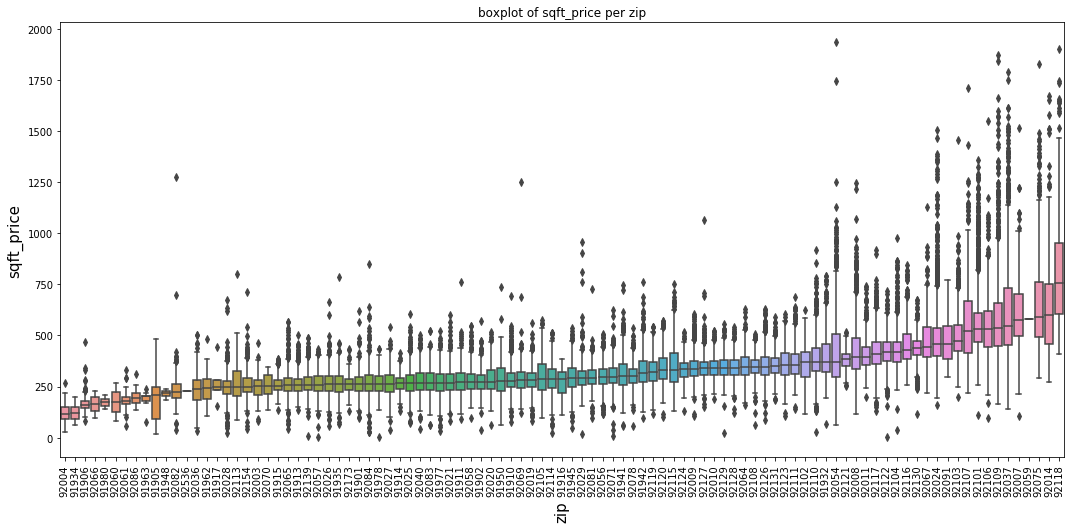

In [75]:
plot_box(df_track, 'zip', 'sqft_price', order=True)

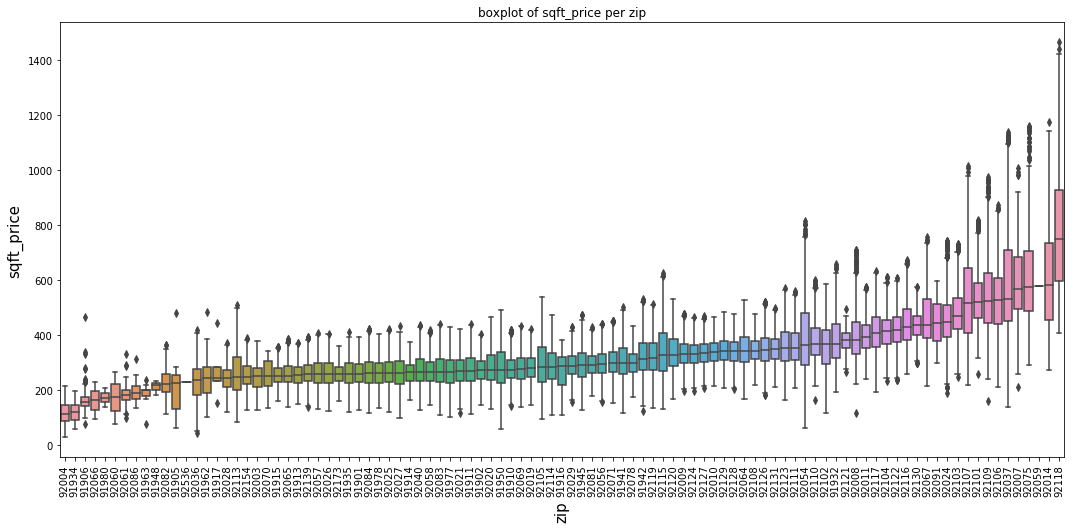

In [80]:
df_track_clean['sqft_price'] = df_track_clean['sold_price'] / df_track_clean['sqft']
plot_box(df_track_clean, 'zip', 'sqft_price', order=True)

In [150]:
stats = pp.get_zip_stats(df_track)
df_bounds = pd.DataFrame.from_dict(stats)
#df_bounds = df1.transpose()

Text(0,0.5,'median')

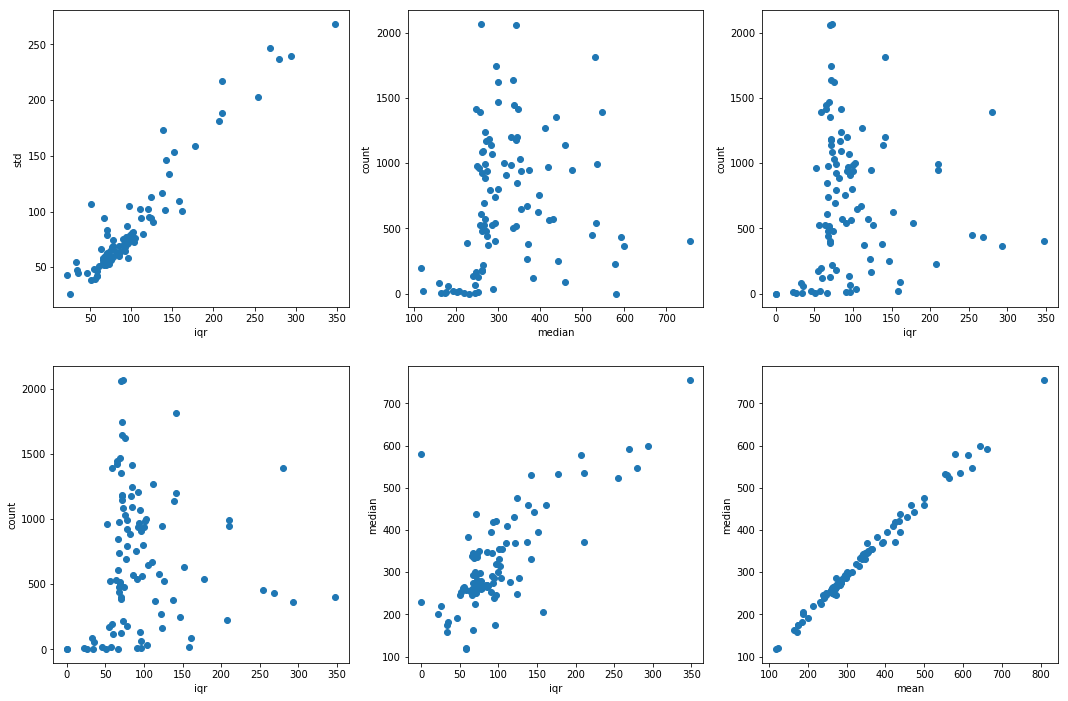

In [159]:
fig, ax = plt.subplots(2,3, figsize=(18,12))
ax[0,0].scatter(df_bounds['iqr'], df_bounds['std'])
ax[0,0].set_xlabel('iqr')
ax[0,0].set_ylabel('std')
ax[0,1].scatter(df_bounds['median'], df_bounds['count'])
ax[0,1].set_xlabel('median')
ax[0,1].set_ylabel('count')
ax[0,2].scatter(df_bounds['iqr'], df_bounds['count'])
ax[0,2].set_xlabel('iqr')
ax[0,2].set_ylabel('count')

ax[1,0].scatter(df_bounds['iqr'], df_bounds['count'])
ax[1,0].set_xlabel('iqr')
ax[1,0].set_ylabel('count')

ax[1,1].scatter(df_bounds['iqr'], df_bounds['median'])
ax[1,1].set_xlabel('iqr')
ax[1,1].set_ylabel('median')

ax[1,2].scatter(df_bounds['mean'], df_bounds['median'])
ax[1,2].set_xlabel('mean')
ax[1,2].set_ylabel('median')

In [121]:
df_bounds[df_bounds['count']<100].sort_values(by='count')

,lower,upper,iqr,count,median
92536,230.113636,230.113636,0.000000,1.0,230.113636
92059,579.601990,579.601990,0.000000,1.0,579.601990
92066,30.443063,297.166387,66.680831,2.0,163.804725
91980,106.960409,241.060026,33.524904,2.0,174.010217
91948,163.328540,266.664945,25.834101,3.0,214.996742
91917,157.708628,359.500236,50.447902,5.0,258.604432
91963,148.567373,235.407210,21.709959,10.0,191.987291
92070,78.366383,441.255437,90.722264,11.0,259.810910
92060,-17.113903,364.899087,95.503248,12.0,173.892592
91934,4.094135,235.341684,57.811887,17.0,119.717910
